In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
print("numpy.version.version = ",np.version.version)
import time
import torch
import pandas as pd
import torch.nn as nn 
import torch.nn.functional as F


numpy.version.version =  1.23.5


In [2]:
from utils import *

## Summary

### Steps involved in the task here:



1. **Model Conversion**: I first defined the Python model class `PythonModel` to mimic the architecture of the given PyTorch model. It has methods for `linear`, `leaky_relu`, `softplus` functions, and a `forward` method to perform the forward propagation.

2. **Error Debugging**: During this process, I encountered runtime warnings and errors (e.g., RuntimeWarning: overflow encountered in exp, AttributeError: 'numpy.ndarray' object has no attribute 'cpu'). Solutions were implemented, which include a more sophisticated approach to handle potential overflow in exponential calculations known as the "log-sum-exp trick", and removing unnecessary conversion to PyTorch Tensor.

3. **Data Transformation**: Modification and careful data handling were performed in the forward method according to the dimensions of the input data to avoid the `ValueError during dimension swapping

4. Testing the Model: The Python model was tested for one event, and successfully produced outputs that match the outputs from the PyTorch model.

5. Mass Testing and Visualization: The process was repeated for multiple events. Differences of outputs from both models are showcased through plots for each event. 

6. Performance: It was noted that the Python model took significant computation time for a single event. I still need to fix the GPU running. potentially I need to use another conda environment (currently I'm using `april2023ME`)

    



In [3]:

# Define the path
path = "/share/lazy/sokoloff/ML/20June2023_VScode_HalfDozen_iter2_500epochs_2em5/20June2023_VScode_HalfDozen_iter2_500epochs_2em5_final.pyt"

# Load the PyTorch model weights
model_weights = torch.load(path, map_location=torch.device('cpu'))

# Initialize dictionaries to store weights and biases as NumPy arrays
weights = {}
biases = {}

# Iterate through the layers and extract weights and biases
for i in range(1, 7):  # Since there are six layers
    weight_key = f"layer{i}.weight"
    bias_key = f"layer{i}.bias"
    
    weights[weight_key] = model_weights[weight_key].numpy() # Convert weight to numpy
    biases[bias_key] = model_weights[bias_key].numpy() # Convert bias to numpy

# Now, 'weights' and 'biases' dictionaries contain the NumPy arrays for each layer

# Now lets print the weights contents



In [4]:
for name, param in model_weights.items():
    print(f"{name}: {param.shape}")

layer1.weight: torch.Size([20, 9])
layer1.bias: torch.Size([20])
layer2.weight: torch.Size([20, 20])
layer2.bias: torch.Size([20])
layer3.weight: torch.Size([20, 20])
layer3.bias: torch.Size([20])
layer4.weight: torch.Size([20, 20])
layer4.bias: torch.Size([20])
layer5.weight: torch.Size([20, 20])
layer5.bias: torch.Size([20])
layer6.weight: torch.Size([100, 20])
layer6.bias: torch.Size([100])


In [5]:
if isinstance(model_weights, dict):
    for key, value in model_weights.items():
        print(f"Key: {key}, Type: {type(value)}")

Key: layer1.weight, Type: <class 'torch.Tensor'>
Key: layer1.bias, Type: <class 'torch.Tensor'>
Key: layer2.weight, Type: <class 'torch.Tensor'>
Key: layer2.bias, Type: <class 'torch.Tensor'>
Key: layer3.weight, Type: <class 'torch.Tensor'>
Key: layer3.bias, Type: <class 'torch.Tensor'>
Key: layer4.weight, Type: <class 'torch.Tensor'>
Key: layer4.bias, Type: <class 'torch.Tensor'>
Key: layer5.weight, Type: <class 'torch.Tensor'>
Key: layer5.bias, Type: <class 'torch.Tensor'>
Key: layer6.weight, Type: <class 'torch.Tensor'>
Key: layer6.bias, Type: <class 'torch.Tensor'>


In [6]:
# lets print the contents and biases
print("Contents of weights", weights)

# print the type of weights
print("Type of weights", type(weights)) 


Contents of weights {'layer1.weight': array([[-2.39243770e+00,  1.30464256e-01,  1.44157395e-01,
         1.71235248e-01, -6.68831840e-02,  1.03701308e-01,
        -2.84958005e-01,  1.00540891e-01,  1.80479631e-01],
       [ 1.84944880e+00,  3.07485819e-01, -2.34383360e-01,
        -1.91112101e-01,  2.98105180e-01,  2.92919755e-01,
        -5.14408171e-01, -3.32461506e-01, -4.81371015e-01],
       [ 2.15168047e+00, -2.79530555e-01, -2.55684108e-01,
        -1.94404364e-01, -5.53289950e-02,  5.55641472e-01,
        -1.05672434e-01, -1.46211654e-01, -7.12540448e-02],
       [-2.22414446e+00, -2.92026907e-01,  1.60329551e-01,
         1.94396615e-01, -8.36265162e-02,  1.41628847e-01,
         1.87526956e-01, -1.66784525e-01, -1.05290124e-02],
       [-1.53005838e+00, -7.75448859e-01,  7.34186411e-01,
         4.24013436e-02, -2.11835980e-01,  2.56287932e-01,
        -3.12074631e-01,  9.02302447e-04, -8.21567774e-02],
       [ 1.45638084e+00,  4.93726432e-02, -1.07808830e-02,
         3.33

In [7]:
# print the biases
print("Contents of biases", biases)

# print the type of biases
print("Type of biases", type(biases))

Contents of biases {'layer1.bias': array([ 0.04636296,  0.07087298,  0.09952483,  0.16813691, -0.01027745,
        0.00601871,  0.10466313, -0.03878294, -0.03412374, -0.04446378,
        0.0375012 ,  0.07540643, -0.04229179,  0.04900113,  0.04046827,
        0.1247687 , -0.09866881,  0.01831979, -0.0072919 ,  0.11979998],
      dtype=float32), 'layer2.bias': array([ 9.18925926e-02,  4.75965515e-02, -7.44393170e-02,  1.09209247e-01,
        7.97329172e-02,  9.62207913e-02, -6.35594651e-02, -5.26137919e-05,
        1.09212168e-01,  1.01869345e-01, -4.18414772e-02, -2.08854020e-01,
        5.63462228e-02,  1.22719459e-01,  6.98987246e-02,  6.01098910e-02,
       -2.03451201e-01, -6.19641840e-02,  1.36885509e-01, -8.44655111e-02],
      dtype=float32), 'layer3.bias': array([ 0.21427123, -0.11512637,  0.24895187,  0.2627717 ,  0.10461821,
        0.2411575 ,  0.02609242,  0.10108724,  0.17866327,  0.28909   ,
        0.1190748 , -0.08345667,  0.0930144 ,  0.05306726, -0.10638557,
       -0.

## Model

In [36]:

class PythonModel:
    def __init__(self, weights, nOut1=25, nOut2=25, nOut3=25, nOut4=25, nOut5=25):
        # Store the weights
        self.weights = weights
        self.nOut1 = nOut1
        self.nOut2 = nOut2
        self.nOut3 = nOut3
        self.nOut4 = nOut4
        self.nOut5 = nOut5

    def linear(self, x, layer):
        # Get the weights (W) and biases (b) for the specified layer
        weight = self.weights[f'layer{layer}.weight'].numpy()
        bias = self.weights[f'layer{layer}.bias'].numpy()
        # Compute the linear step of the neural network (perform the linear transformation)
        return np.dot(x, weight.T) + bias # Equivalent to: x @ W + b

    def leaky_relu(self, x, negative_slope=0.01):
        # Compute the leaky ReLU activation function
        return np.maximum(0, x) + negative_slope * np.minimum(0, x) # Equivalent to: max(0, x) + negative_slope * min(0, x)

    def softplus(self, x):
        # Compute the leaky ReLU activation function
        # Use the log-sum-exp trick to avoid overflow
        b = np.max(x)
        return b + np.log(np.exp(x - b) + np.exp(0 - b)) # Equivalent to: b + log(exp(x - b) + exp(0 - b))
    
    def forward(self, x):
        # Reshape the input data if necessary
        if len(x.shape) == 3:
            x = x.transpose(0, 2, 1)
        # Compute the linear step    
        x = self.leaky_relu(self.linear(x, 1))
        x = self.leaky_relu(self.linear(x, 2))
        x = self.leaky_relu(self.linear(x, 3))
        x = self.leaky_relu(self.linear(x, 4))
        x = self.leaky_relu(self.linear(x, 5))
        # Compute the softplus step
        x = self.softplus(self.linear(x, 6))
        # Reshape the output
        x = x.reshape(x.shape[0], -1, 100)
        # Sum across the first dimension
        y_pred = np.sum(x, axis=1) * 0.001
        # Return the predicted y values
        return y_pred


### Class `PythonModel`

##### `__init__` Method
The `__init__` method initializes the model with given weights and output dimensions for each layer.

- `self.weights = weights`: Assigns the weights for each layer of the neural network.
- `self.nOut1, self.nOut2, self.nOut3, self.nOut4, self.nOut5 = nOut1, nOut2, nOut3, nOut4, nOut5`: Assigns output dimensions for each layer.

##### `linear` Method
The `linear` method computes the linear transformation for a given layer:
- `weight = self.weights[f'layer{layer}.weight'].numpy()`: Retrieves the weights for the specified layer.
- `bias = self.weights[f'layer{layer}.bias'].numpy()`: Retrieves the bias for the specified layer.
- `return np.dot(x, weight.T) + bias`: Returns the result of the linear transformation, described by the equation $$ y = \mathbf{x} \cdot \mathbf{W}^T + \mathbf{b} $$.

##### `leaky_relu` Method
The `leaky_relu` method computes the Leaky ReLU activation function, described by the equation:

$$ f(x) = \max(0, x) + \text{negative\_slope} \times \min(0, x) $$

##### `softplus` Method
The `softplus` method computes the Softplus activation function using the log-sum-exp trick:
- `b = np.max(x)`: Finds the maximum value in x.
- `return b + np.log(np.exp(x - b) + np.exp(0 - b))`: Returns the Softplus activated output, described by the equation:

$$ f(x) = b + \log(\exp(x - b) + \exp(0 - b)) $$

##### `forward` Method
The `forward` method computes the forward pass through the neural network:
- `if len(x.shape) == 3: x = x.transpose(0, 2, 1)`: Transposes the input if it has 3 dimensions.
- `x = self.leaky_relu(self.linear(x, i))`: Passes the input through the first five hidden layers using the Leaky ReLU activation function.
- `x = self.softplus(self.linear(x, 6))`: Passes the output through the Softplus activation function.
- `x = x.reshape(x.shape[0], -1, 100)`: Reshapes the output.
- `y_pred = np.sum(x, axis=1) * 0.001`: Sums the output and scales it by 0.001 to obtain the final prediction.

The final predicted output is returned as `y_pred`.

---

This deep learning model performs a series of linear transformations followed by Leaky ReLU activation functions, concluding with a Softplus activation function. Without the corresponding context or additional information on the specific problem being solved, it might be challenging to provide a more in-depth interpretation of the model's behavior or purpose.


In [9]:
# This is a fully connected network with 6 layers and LeakyReLU activations for the first 5 layers. The last layer uses a Softplus activation. 
# The input is transposed before being passed through the layers, and a mask is applied to the output
class Model(nn.Module):
    softplus = torch.nn.Softplus()

    def __init__(self, nOut1=25, nOut2=25, nOut3=25,
                       nOut4=25, nOut5=25):
        super(Model,self).__init__()

        self.nOut1 = nOut1
        self.nOut2 = nOut2
        self.nOut3 = nOut3
        self.nOut4 = nOut4
        self.nOut5 = nOut5
       

        self.layer1 = nn.Linear(
                    in_features = 9,
                    out_features = self.nOut1,
                    bias = True)
        self.layer2 = nn.Linear(
                    in_features = self.layer1.out_features,
                    out_features = self.nOut2,
                    bias = True)
        self.layer3 = nn.Linear(
                    in_features = self.layer2.out_features,
                    out_features = self.nOut3,
                    bias = True)
        self.layer4 = nn.Linear(
                    in_features = self.layer3.out_features,
                    out_features = self.nOut4,
                    bias = True)
        self.layer5 = nn.Linear(
                    in_features = self.layer4.out_features,
                    out_features = self.nOut5,
                    bias = True)
        self.layer6 = nn.Linear(
                    in_features = self.layer5.out_features,
                    out_features = 100,
                    bias = True)
        
    def forward(self, x):
        
        leaky = nn.LeakyReLU(0.01)
        nEvts     = x.shape[0]
        nFeatures = x.shape[1]
        nTrks     = x.shape[2]
        mask = x[:,0,:] > -98.
        filt = mask.float()
        f1 = filt.unsqueeze(2)
        f2 = f1.expand(-1,-1,100)
        x = x.transpose(1,2)
        ones = torch.ones(nEvts,nFeatures,nTrks)
        x0 = x 
        x = leaky(self.layer1(x))
        x = leaky(self.layer2(x))
        x = leaky(self.layer3(x))
        x = leaky(self.layer4(x))
        x = leaky(self.layer5(x))
        x = (self.layer6(x))  
        x = self.softplus(x)
       
        x.view(nEvts,-1,100)

        x1 = torch.mul(f2,x)
        x1.view(nEvts,-1,100)
        y_prime = torch.sum(x1,dim=1)        
        y_pred = torch.mul(y_prime,0.001)
        return y_pred

## Run things


In [10]:
validation = collect_t2kde_data('/share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5',
batch_size=64,
pin_memory=True,
shuffle=False,
)

Loading data...


  
kernel.shape =  (51314, 4000)
kernel.shape[0] =  51314
kernel.shape[1] =  4000
Y.shape =       (51314, 12000)
binsPerInterval =  100
nIntervals =        40
intervalKernels.shape =  (2052560, 100)
pocaMx.shape =  (51314,)
nEvts =  51314
pocaz.shape =  (51314,)
len(pocaMx[0]) =  119
len(pocaMx[1]) =  317
len(pocaMx[2]) =  260
len(pocaMx[3]) =  133
len(pocaMx[4]) =  196
 iEvt, nTrks =  0 119
 iEvt, nTrks =  1 317
 iEvt, nTrks =  2 260
 iEvt, nTrks =  3 133
 iEvt, nTrks =  4 196
 iEvt, nTrks =  5 109
 iEvt, nTrks =  6 211
 iEvt, nTrks =  7 179
 iEvt, nTrks =  8 258
 iEvt, nTrks =  9 324
 BAD ---- iEvt, iTrk =  123 154
 BAD ---- iEvt, iTrk =  2460 203
 BAD ---- iEvt, iTrk =  4484 129
 BAD ---- iEvt, iTrk =  4511 201
 BAD ---- iEvt, iTrk =  5575 132
 BAD ---- iEvt, iTrk =  8120 204
 BAD ---- iEvt, iTrk =  8747 364
 BAD ---- iEvt, iTrk =  9983 22
 BAD ---- iEvt, iTrk =  10651 235
 BAD ---- iEvt, iTrk =  11956 196
 BAD ---- iEvt, iTrk =  12010 77
 BAD ---- iEvt, iTrk =  13523 25
 BAD ---- i

In [11]:
device = select_gpu(2)

Selecting CPU (CUDA not available)


/data/home/melashri/.conda/envs/april2023ME/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402412426/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:
original_weights = '/share/lazy/sokoloff/ML/26August_testing_HalfDozen_first_learning_iter5A_200epochs_2em5_fullLHCbMC_scrubbedData/26August_testing_HalfDozen_first_learning_iter5A_200epochs_2em5_fullLHCbMC_scrubbedData_final.pyt'


nOut1 = 20
nOut2 = 20
nOut3 = 20
nOut4 = 20
nOut5 = 20
original_model = Model(nOut1,nOut2,nOut3,nOut4,nOut5)
d_original = torch.load(original_weights, map_location=torch.device('cpu') )
original_model.load_state_dict(d_original)
original_model.eval()

Model(
  (layer1): Linear(in_features=9, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=20, bias=True)
  (layer6): Linear(in_features=20, out_features=100, bias=True)
)

In [23]:
with torch.no_grad():
    print("device = ",device)
    print("validation.dataset.tensors[0].shape = ",validation.dataset.tensors[0].shape)
    vdt0 = validation.dataset.tensors[0]
    vdt1 = validation.dataset.tensors[1]
    print("vdt0.shape = ",vdt0.shape)
    print("vdt1.shape = ",vdt1.shape)
    nSplit = []
    for ii in range(20):
        nSplit.append((ii+1)*100000)
        
    print("nSplit = ",nSplit)  
    
    
    vdt0Split = torch.tensor_split(vdt0,nSplit, dim=0)
    vdt1Split = torch.tensor_split(vdt1,nSplit, dim=0)

    print("len(vdt0Split) = ",len(vdt0Split))
    
    defaultSplitSize = vdt0Split[0].shape[0]
    print("defaultSpitSize = ",defaultSplitSize)


device =  cpu
validation.dataset.tensors[0].shape =  torch.Size([2051640, 9, 250])
vdt0.shape =  torch.Size([2051640, 9, 250])
vdt1.shape =  torch.Size([2051640, 100])
nSplit =  [100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1100000, 1200000, 1300000, 1400000, 1500000, 1600000, 1700000, 1800000, 1900000, 2000000]
len(vdt0Split) =  21
defaultSpitSize =  100000


## One event

data shape = torch.Size([100000, 9, 250])


TypeError: 'numpy.float64' object is not iterable

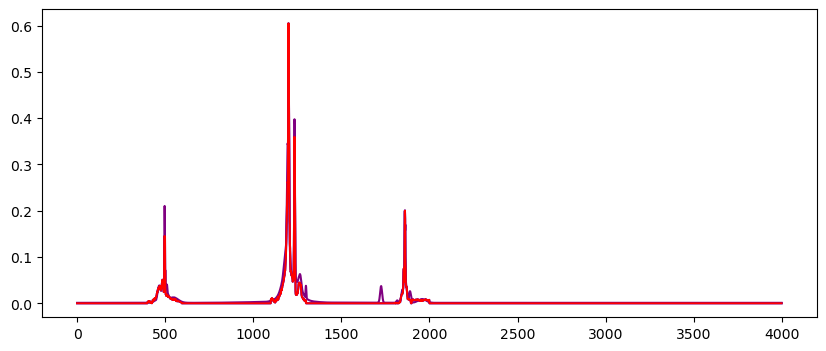

In [38]:
# Load the weights into the Python model
python_model = PythonModel(d_original, nOut1, nOut2, nOut3, nOut4, nOut5)

with torch.no_grad():
    for iChunk in range(1):
       print("data shape =", vdt0Split[iChunk].shape) 
       original_outputs_python_based = python_model.forward(vdt0Split[iChunk].numpy())
        
       # Convert the PyTorch tensor to a NumPy array for the Python model
       inputs_python = vdt0Split[iChunk].numpy()
        
       labels = vdt1Split[iChunk].numpy()
       inputs = vdt0Split[iChunk].numpy()

       # Use the Python model to make predictions
       python_outputs = python_model.forward(inputs_python)
       
num_intervals_per_event=40
listOfEvents = np.arange(1)
for jj in listOfEvents:
   event_labels=[]
   event_original_outputs=[]
   event_python_outputs=[]

   for i in range(num_intervals_per_event):

      interval=jj*num_intervals_per_event+i
      
      if interval>=len(inputs): break 

      input=inputs[interval]
      label=labels[interval]
      
      original_output_python_based=original_outputs_python_based[interval]
      
      # Get the corresponding output from the Python model
      python_output = python_outputs[interval]

      
      event_labels.append(label)
      
      event_original_outputs.append(original_output_python_based)
      
      # Add the Python output to the list
      event_python_outputs.append(python_output)

   
event_label=np.concatenate(event_labels)

event_original_output=np.concatenate(event_original_outputs)

# Concatenate the Python outputs
event_python_output = np.concatenate(event_python_outputs)


plt.figure()
plt.plot(event_label,color='purple',label='target KDE')
plt.plot(event_original_output,color='blue',label='original prediction')
# Add the Python model's predictions to the plot
plt.plot(event_python_output, color='red', label='Python prediction')
ymax = max(1.1*np.max(event_label), 1.1*np.max(event_python_output), 1.1*np.max(event_original_output))
plt.ylim((0., ymax))
plt.legend()
plt.show()

print("event =", jj)
print(' ')
print(' ------------------------------- ')
print(' ')


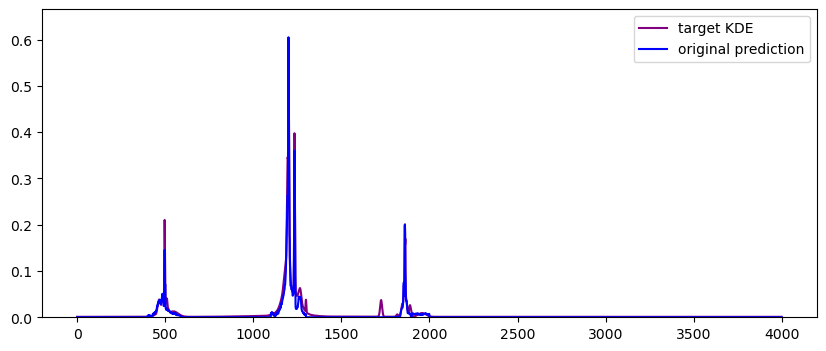

event = 0
 
 ------------------------------- 
 


In [43]:
plt.figure()
plt.plot(event_label,color='purple',label='target KDE')
plt.plot(event_original_output,color='blue',label='original prediction')
# Add the Python model's predictions to the plot
#plt.plot(event_python_output, color='red', label='Python prediction')
ymax = max(1.1*np.max(event_label), 1.1*np.max(event_python_output), 1.1*np.max(event_original_output))
plt.ylim((0., ymax))
plt.legend()
plt.show()

print("event =", jj)
print(' ')
print(' ------------------------------- ')
print(' ')


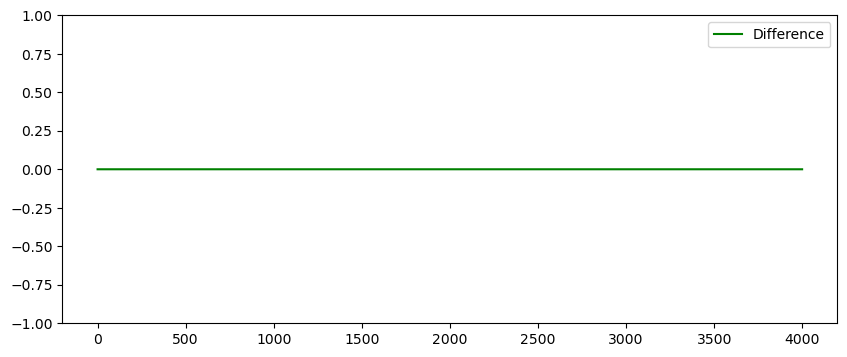

In [46]:
# Calculate the difference between the Python and PyTorch predictions
difference = event_python_output - event_original_output

plt.figure()
plt.plot(difference, color='green', label='Difference')
# Add a small buffer to the y-axis limits
ylim = np.max(np.abs(difference))
if ylim == 0:
    ylim = 1  # Or any other small number
plt.ylim((-ylim, ylim))
plt.legend()
plt.show()


## try with 10 events

data shape = torch.Size([100000, 9, 250])


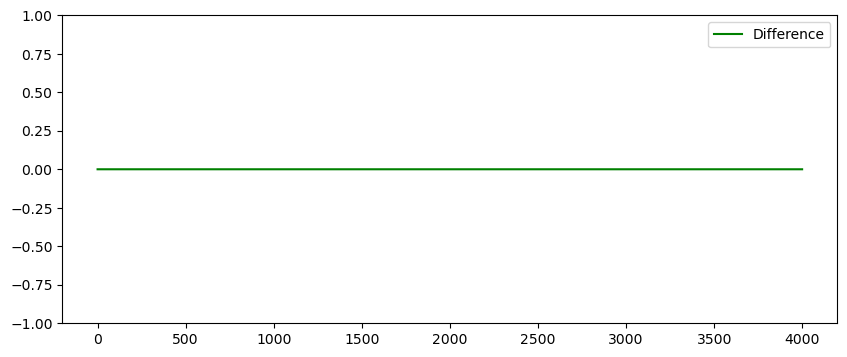

event = 0
 
 ------------------------------- 
 


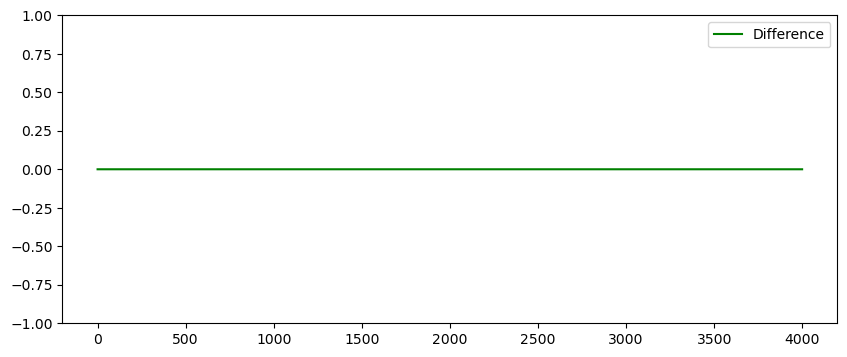

event = 1
 
 ------------------------------- 
 


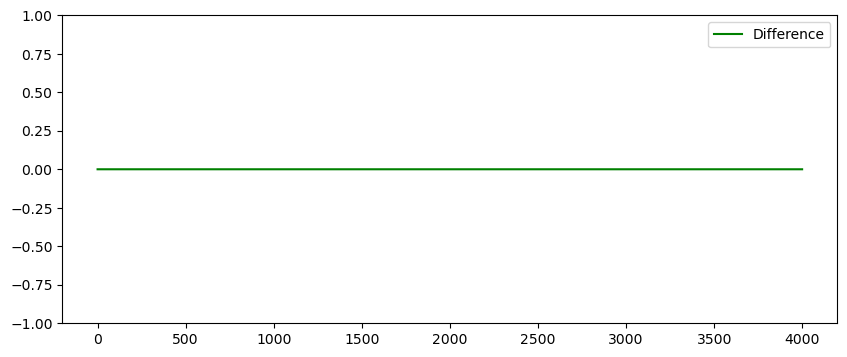

event = 2
 
 ------------------------------- 
 


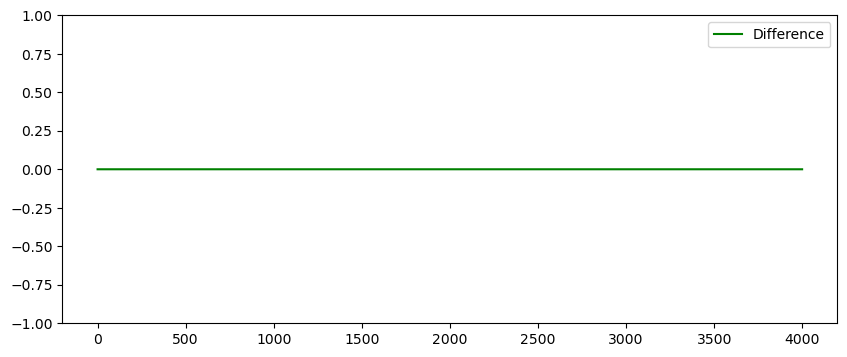

event = 3
 
 ------------------------------- 
 


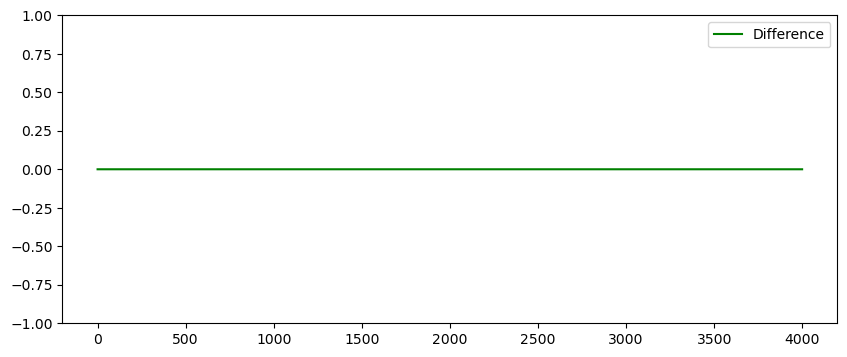

event = 4
 
 ------------------------------- 
 


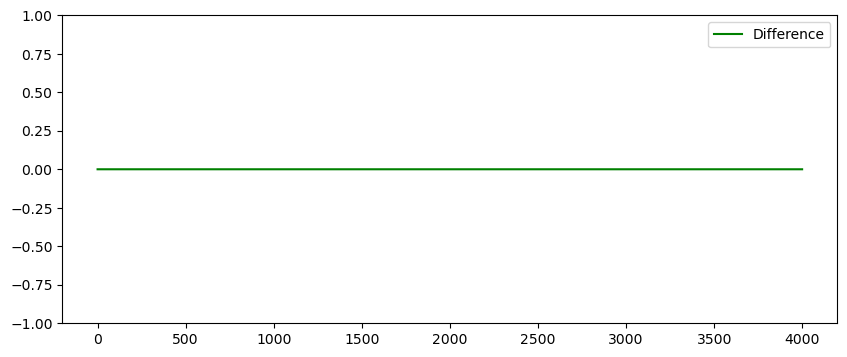

event = 5
 
 ------------------------------- 
 


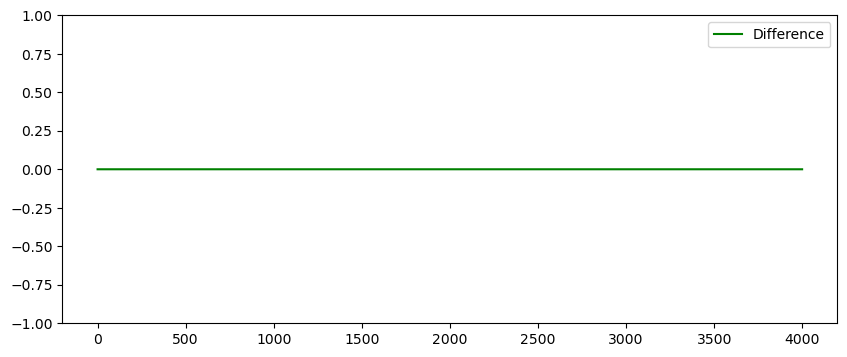

event = 6
 
 ------------------------------- 
 


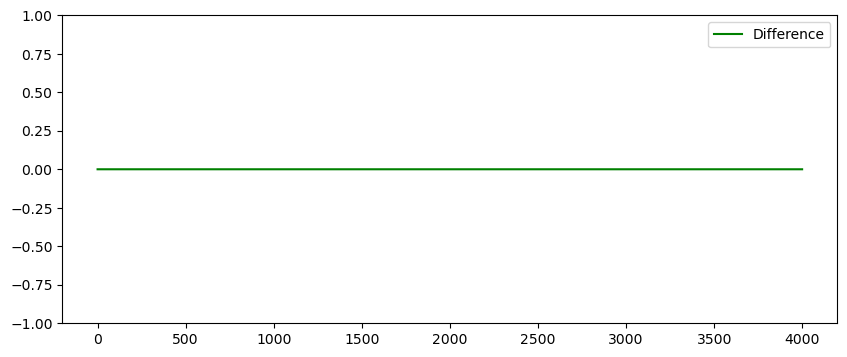

event = 7
 
 ------------------------------- 
 


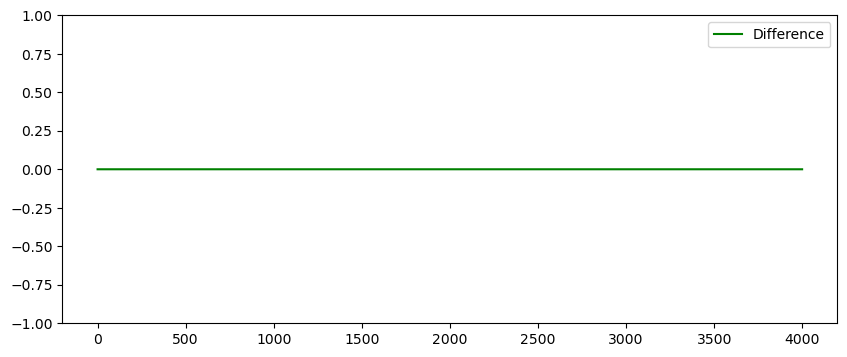

event = 8
 
 ------------------------------- 
 


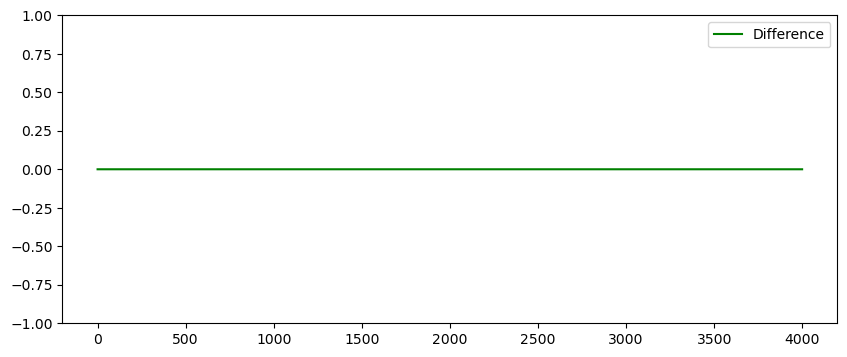

event = 9
 
 ------------------------------- 
 


In [47]:
# Load the weights into the Python model
python_model = PythonModel(d_original, nOut1, nOut2, nOut3, nOut4, nOut5)

with torch.no_grad():
    for iChunk in range(1):
       print("data shape =", vdt0Split[iChunk].shape) 
       original_outputs_python_based = python_model.forward(vdt0Split[iChunk].numpy())
        
       # Convert the PyTorch tensor to a NumPy array for the Python model
       inputs_python = vdt0Split[iChunk].numpy()
        
       labels = vdt1Split[iChunk].numpy()
       inputs = vdt0Split[iChunk].numpy()

       # Use the Python model to make predictions
       python_outputs = python_model.forward(inputs_python)
       
num_intervals_per_event=40
listOfEvents = np.arange(10)
for jj in listOfEvents:
   event_labels=[]
   event_original_outputs=[]
   event_python_outputs=[]

   for i in range(num_intervals_per_event):

      interval=jj*num_intervals_per_event+i
      
      if interval>=len(inputs): break 

      input=inputs[interval]
      label=labels[interval]
      
      original_output_python_based=original_outputs_python_based[interval]
      
      # Get the corresponding output from the Python model
      python_output = python_outputs[interval]

      
      event_labels.append(label)
      
      event_original_outputs.append(original_output_python_based)
      
      # Add the Python output to the list
      event_python_outputs.append(python_output)

   
   event_label=np.concatenate(event_labels)

   event_original_output=np.concatenate(event_original_outputs)

   # Concatenate the Python outputs
   event_python_output = np.concatenate(event_python_outputs)

   # Calculate the difference between the Python and PyTorch predictions
   difference = event_python_output - event_original_output

   plt.figure()
   plt.plot(difference, color='green', label='Difference')
   # Add a small buffer to the y-axis limits
   ylim = np.max(np.abs(difference))
   if ylim == 0:
       ylim = 1  # Or any other small number
   plt.ylim((-ylim, ylim))
   plt.legend()
   plt.show()

   print("event =", jj)
   print(' ')
   print(' ------------------------------- ')
   print(' ')


## Subplot visualization of the models

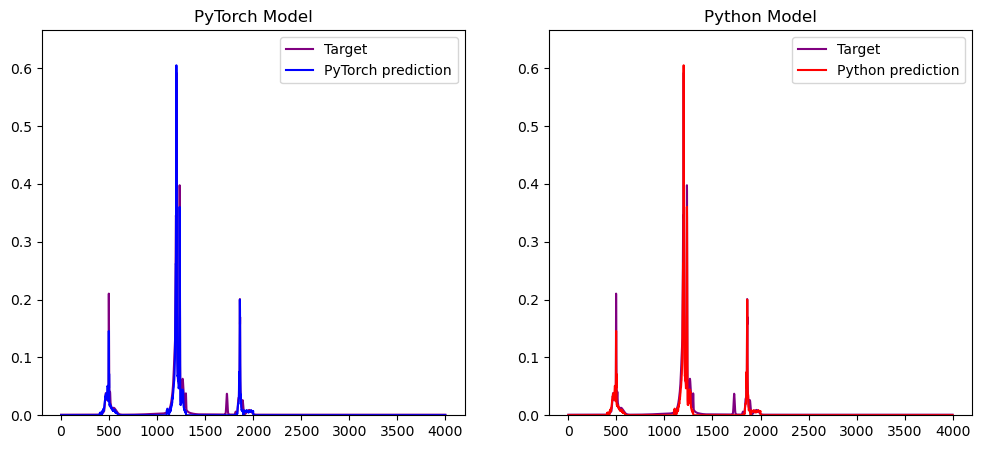

event = 0
 
 ------------------------------- 
 


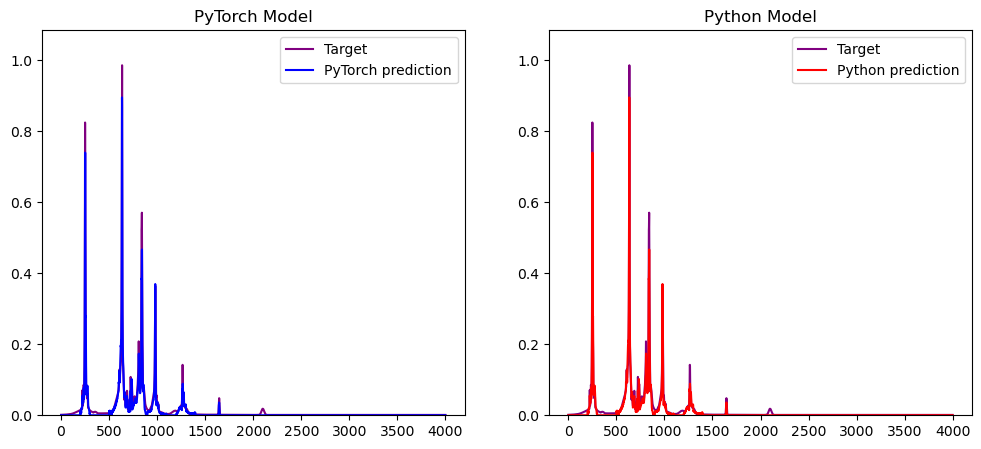

event = 1
 
 ------------------------------- 
 


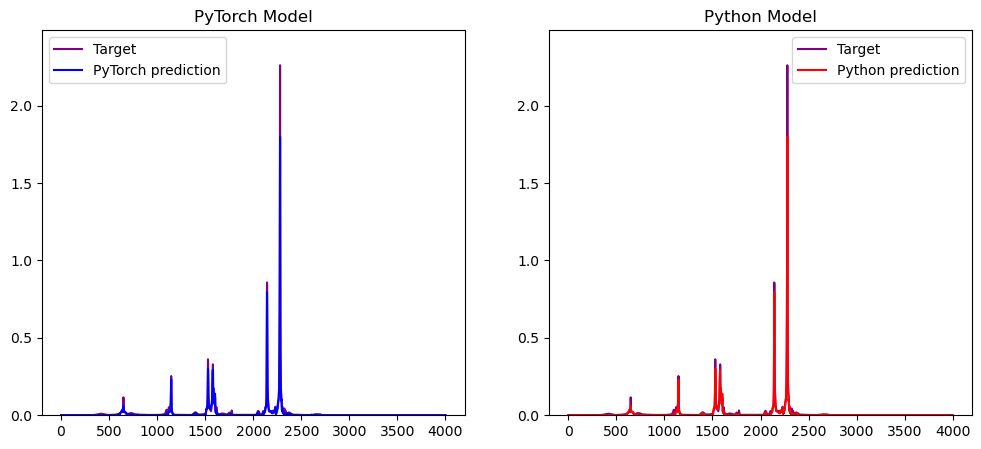

event = 2
 
 ------------------------------- 
 


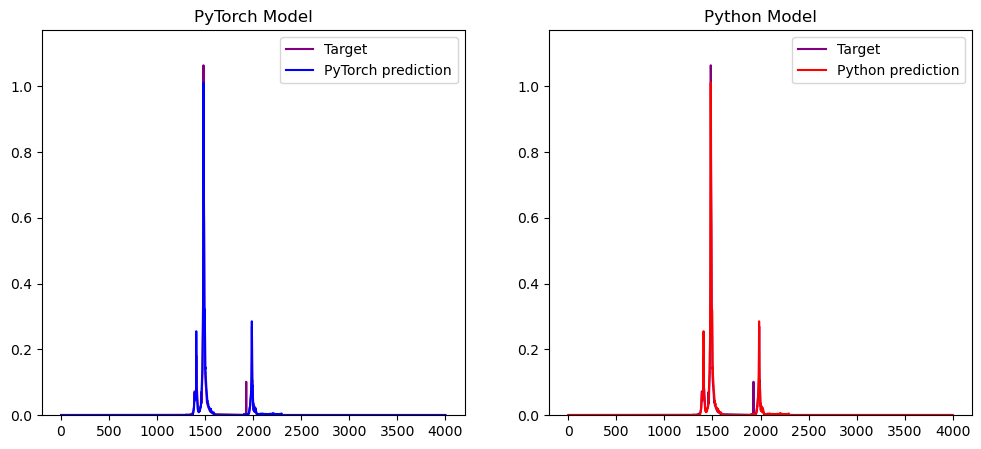

event = 3
 
 ------------------------------- 
 


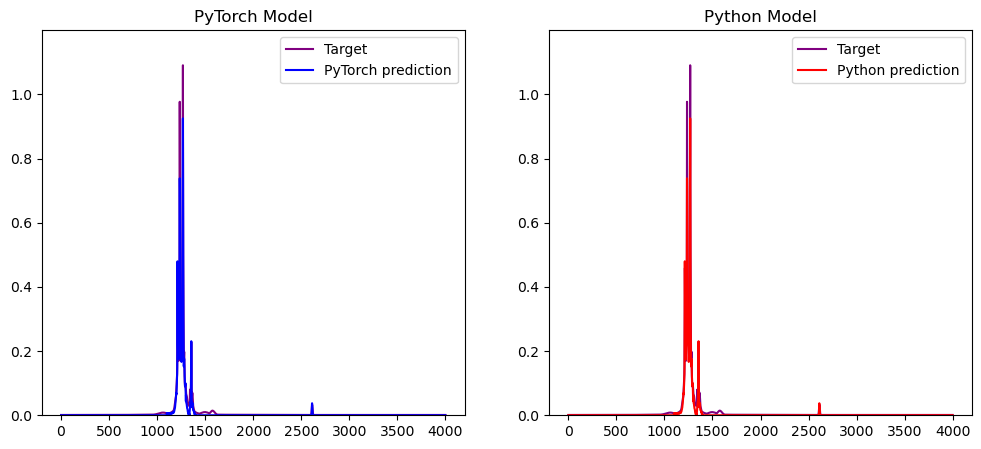

event = 4
 
 ------------------------------- 
 


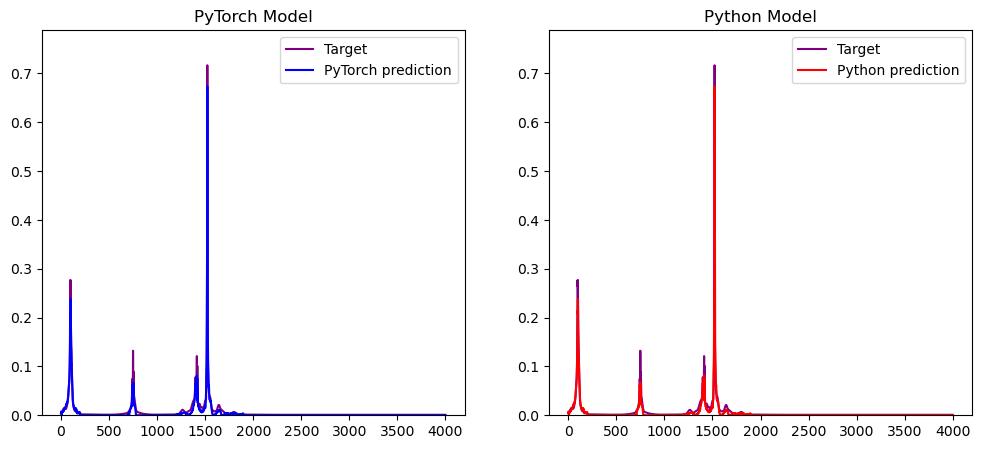

event = 5
 
 ------------------------------- 
 


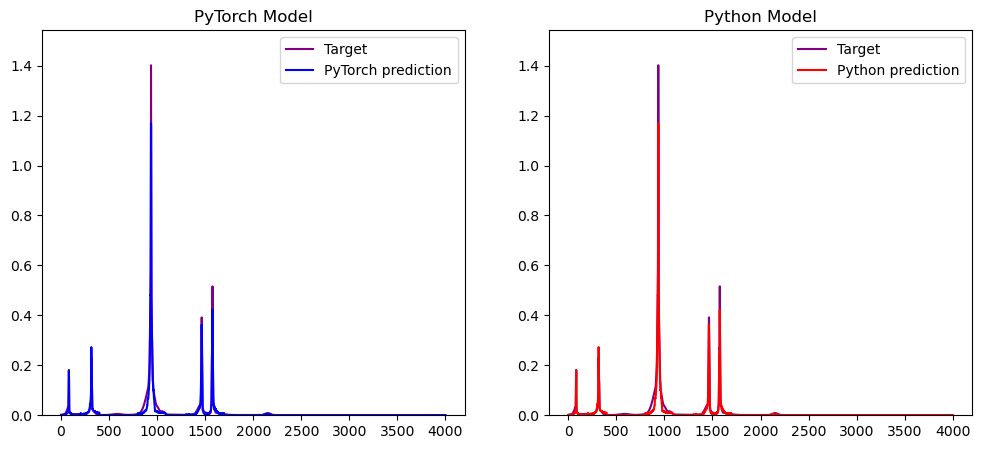

event = 6
 
 ------------------------------- 
 


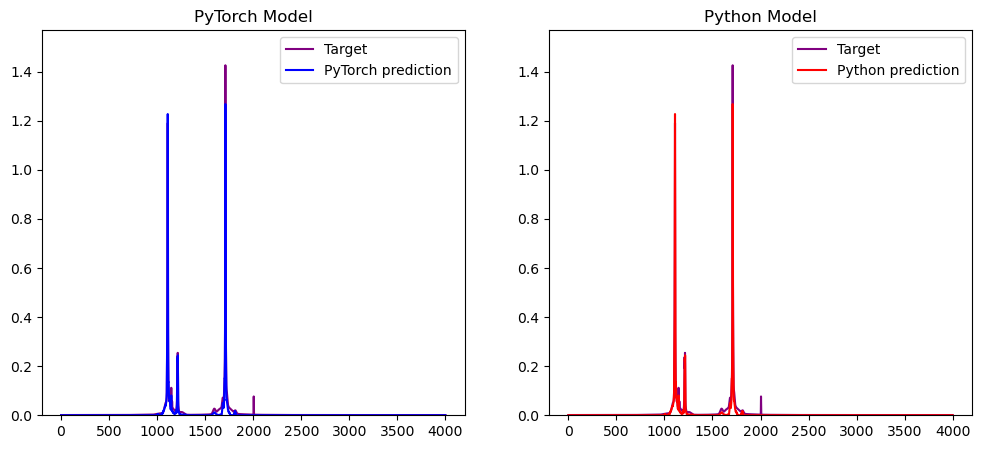

event = 7
 
 ------------------------------- 
 


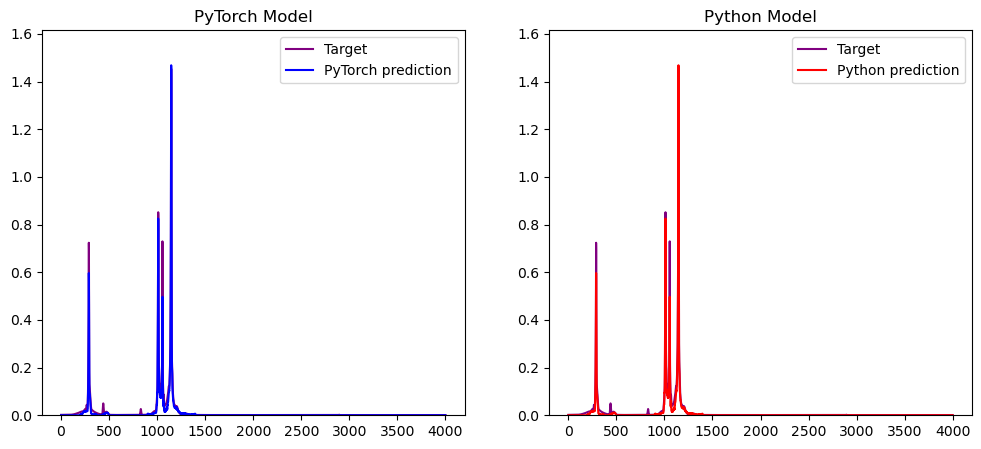

event = 8
 
 ------------------------------- 
 


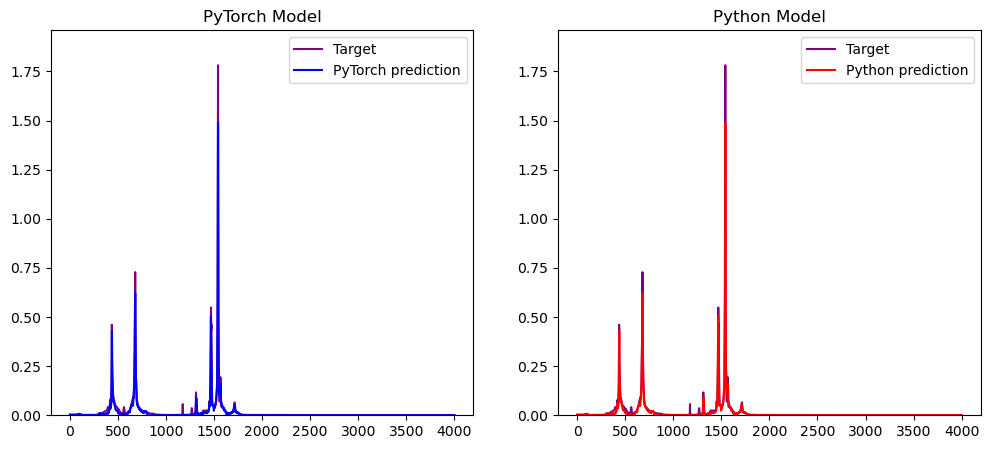

event = 9
 
 ------------------------------- 
 


In [50]:
num_intervals_per_event=40
listOfEvents = np.arange(10)
for jj in listOfEvents:
   event_labels=[]
   event_original_outputs=[]
   event_python_outputs=[]

   for i in range(num_intervals_per_event):

      interval=jj*num_intervals_per_event+i
      
      if interval>=len(inputs): break 

      input=inputs[interval]
      label=labels[interval]
      
      original_output_python_based=original_outputs_python_based[interval]
      
      # Get the corresponding output from the Python model
      python_output = python_outputs[interval]

      
      event_labels.append(label)
      
      event_original_outputs.append(original_output_python_based)
      
      # Add the Python output to the list
      event_python_outputs.append(python_output)

   
   event_label=np.concatenate(event_labels)

   event_original_output=np.concatenate(event_original_outputs)

   # Concatenate the Python outputs
   event_python_output = np.concatenate(event_python_outputs)

   # Create a figure with two subplots
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

   # Plot the target and PyTorch predictions on the first subplot
   ax1.plot(event_label, color='purple', label='Target')
   ax1.plot(event_original_output, color='blue', label='PyTorch prediction')
   ax1.set_ylim((0., max(1.1*np.max(event_label), 1.1*np.max(event_original_output))))
   ax1.legend()
   ax1.set_title('PyTorch Model')

   # Plot the target and Python predictions on the second subplot
   ax2.plot(event_label, color='purple', label='Target')
   ax2.plot(event_python_output, color='red', label='Python prediction')
   ax2.set_ylim((0., max(1.1*np.max(event_label), 1.1*np.max(event_python_output))))
   ax2.legend()
   ax2.set_title('Python Model')

   plt.show()

   print("event =", jj)
   print(' ')
   print(' ------------------------------- ')
   print(' ')
